In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.random.random([10, 1, 2, 3])
W = np.random.random([4, 3, 1])
y = np.matmul(x, W)
y.shape

(10, 4, 2, 1)

In [ ]:
class BatchDense(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_neurons, activation):
        super().__init__()
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.activation = activation if activation else lambda x: x
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(self.num_layers, input_shape[-1], self.num_neurons),
                               initializer='he_uniform',
                               trainable=True)
        self.b = self.add_weight(shape=(self.num_layers, 1, self.num_neurons),
                               initializer='zeros',
                               trainable=True)
    
    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

class MixerMLP(tf.keras.layers.Layer):
    def __init__(self, num_layers, outsize, hiddensize=None):
        super().__init__()
        hiddensize = hiddensize if hiddensize else outsize
        self.layer_1 = BatchDense(num_layers, hiddensize, tf.nn.gelu)
        self.layer_2 = BatchDense(num_layers, outsize, None)

    def call(self, inputs):
        h = self.layer_1(inputs)
        return self.layer_2(h)

class Mixer(tf.keras.layers.Layer):
    def __init__(self, num_layers, outheight, outwidth):
        super().__init__()
        self.layer_1 = MixerMLP(num_layers, outheight)
        self.layer_2 = MixerMLP(num_layers, outwidth)

    def call(self, inputs):
        h = tf.keras.layers.Permute((1, 3, 2))(inputs)
        h = self.layer_1(h)
        h = tf.keras.layers.Permute((1, 3, 2))(h)
        return self.layer_2(h)

class ZeroFilter(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.a = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        return self.a * inputs

In [ ]:
def resnet_mixer(height, width, depth, num_classes, n_repeat, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    expanded = tf.keras.layers.Reshape((1, height, width))(inputs)    
    h = expanded

    for i in range(n_repeat):
        h = ZeroFilter()(Mixer(depth, height, width)(h)) + h
    
    rows_out = MixerMLP(depth, 1)(h)
    rows_out = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(rows_out)

    cols_out = tf.keras.layers.Permute((1, 3, 2))(h)
    cols_out = MixerMLP(depth, 1)(cols_out)
    cols_out = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(cols_out)

    concat = tf.keras.layers.Concatenate()([rows_out, cols_out])
    av = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(concat)  # average depthwise
    flat = tf.keras.layers.Flatten()(av)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)


def repeated_patchless_mixer_2(height, width, hidden_dim, size, num_classes, n_repeat, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    expanded = tf.keras.layers.Reshape((1, height, width))(inputs)    
    h = Mixer(size, hidden_dim, hidden_dim)(expanded)

    for i in range(n_repeat):
        h = ZeroFilter()(Mixer(size, hidden_dim, hidden_dim)(h)) + h
    
    rows_out = MixerMLP(size, 1)(h)
    rows_out = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(rows_out)

    cols_out = tf.keras.layers.Permute((1, 3, 2))(h)
    cols_out = MixerMLP(size, 1)(cols_out)
    cols_out = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(cols_out)

    concat = tf.keras.layers.Concatenate()([rows_out, cols_out])
    flat = tf.keras.layers.Flatten()(concat)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)


def repeated_patchless_mixer(height, width, hidden_dim, size, num_classes, n_repeat, name=None):
    "Closer to original, with averaged layer."
    inputs = tf.keras.layers.Input(shape=(height, width))
    expanded = tf.keras.layers.Reshape((1, height, width))(inputs)
    row_wise = MixerMLP(size, hidden_dim)(expanded)
    transposed = tf.keras.layers.Permute((1, 3, 2))(row_wise)
    col_wise = MixerMLP(size, hidden_dim)(transposed)
    h_ = col_wise
    for i in range(n_repeat):
        h = tf.keras.layers.Permute((1, 3, 2))(h_)
        h = MixerMLP(size, hidden_dim)(h)
        h = tf.keras.layers.Permute((1, 3, 2))(h)
        h = MixerMLP(size, hidden_dim)(h)
        h_ = h + h_
    averaged = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(col_wise)
    flat = tf.keras.layers.Flatten()(h_)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)

def patchless_mixer(height, width, hidden_dim, depth, num_classes, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    expanded = tf.keras.layers.Reshape((1, height, width))(inputs)
    row_wise = MixerMLP(depth, hidden_dim)(expanded)
    transposed = tf.keras.layers.Permute((1, 3, 2))(row_wise)
    col_wise = MixerMLP(depth, hidden_dim)(transposed)
    averaged = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1))(col_wise)
    flat = tf.keras.layers.Flatten()(averaged)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)

def blender(height, width, size, num_classes, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    expanded = tf.keras.layers.Reshape((1, height, width))(inputs)
    row_wise = BatchDense(size, 1)(expanded)
    transposed = tf.keras.layers.Permute((1, 3, 2))(row_wise)
    col_wise = BatchDense(size, 1)(transposed)
    flattened = tf.keras.layers.Flatten()(col_wise)
    y = tf.keras.layers.Dense(num_classes)(flattened)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)

def wider_blender(height, width, hiddensize, size, num_classes, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    expanded = tf.keras.layers.Reshape((1, height, width))(inputs)
    row_wise = MixerMLP(size, hiddensize, 1)(expanded)
    transposed = tf.keras.layers.Permute((1, 3, 2))(row_wise)
    col_wise = MixerMLP(size, hiddensize, 1)(transposed)
    flattened = tf.keras.layers.Flatten()(col_wise)
    y = tf.keras.layers.Dense(num_classes)(flattened)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)


# MNIST

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)
train_images, test_images = tf.constant(train_images), tf.constant(test_images)

height, width = train_images.shape[-2:]
num_classes = 10

In [ ]:
"RESNET MIXER"
hidden_dim = 64
n_repeat = 2
depth = 16
model = resnet_mixer(height, width, depth, num_classes, n_repeat)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_165"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_196 (InputLayer)          [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_184 (Reshape)           (None, 1, 28, 28)    0           input_196[0][0]                  
__________________________________________________________________________________________________
mixer_12 (Mixer)                (None, 16, 28, 28)   51968       reshape_184[0][0]                
__________________________________________________________________________________________________
zero_filter_6 (ZeroFilter)      (None, 16, 28, 28)   1           mixer_12[0][0]                   
__________________________________________________________________________________________

In [ ]:
"DEEPER REPEATED PATCHLESS MIXER ROW-COL CLASSIFICATION"
num_classes = 10
hidden_dim = 64
n_repeat = 2
depth = 8
model = repeated_patchless_mixer_2(height, width, hidden_dim, depth, num_classes, n_repeat)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_163"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_194 (InputLayer)          [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_182 (Reshape)           (None, 1, 28, 28)    0           input_194[0][0]                  
__________________________________________________________________________________________________
mixer_mlp_437 (MixerMLP)        (None, 8, 28, 64)    48128       reshape_182[0][0]                
__________________________________________________________________________________________________
permute_451 (Permute)           (None, 8, 64, 28)    0           mixer_mlp_437[0][0]              
__________________________________________________________________________________________

In [ ]:
"DEEPER REPEATED PATCHLESS MIXER"
num_classes = 10
hidden_dim = 28
n_repeat = 3
depth = 8
model = repeated_patchless_mixer(height, width, hidden_dim, depth, num_classes, n_repeat)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

In [ ]:
"REPEATED PATCHLESS MIXER"  # todo allow multichannel
num_classes = 10
hidden_dim = 28
n_repeat = 3
depth = 1
model = repeated_patchless_mixer(height, width, hidden_dim, depth, num_classes, n_repeat)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_126"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_152 (InputLayer)          [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_140 (Reshape)           (None, 1, 28, 28)    0           input_152[0][0]                  
__________________________________________________________________________________________________
mixer_mlp_40 (MixerMLP)         (None, 1, 28, 32)    1984        reshape_140[0][0]                
__________________________________________________________________________________________________
permute_109 (Permute)           (None, 1, 32, 28)    0           mixer_mlp_40[0][0]               
__________________________________________________________________________________________

In [ ]:
"PATCHLESS MIXER"
num_classes = 10
hidden_dim = 28
depth = 32
model = patchless_mixer(height, width, hidden_dim, depth, num_classes)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_149 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
reshape_138 (Reshape)        (None, 1, 28, 28)         0         
_________________________________________________________________
mixer_mlp_38 (MixerMLP)      (None, 32, 28, 32)        63488     
_________________________________________________________________
permute_101 (Permute)        (None, 32, 32, 28)        0         
_________________________________________________________________
mixer_mlp_39 (MixerMLP)      (None, 32, 32, 32)        63488     
_________________________________________________________________
lambda_37 (Lambda)           (None, 32, 32)            0         
_________________________________________________________________
flatten_89 (Flatten)         (None, 1024)              0 

In [ ]:
"BLENDER"
num_classes = 10
size = 256
model = blender(height, width, size, num_classes)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_128 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
reshape_122 (Reshape)        (None, 1, 28, 28)         0         
_________________________________________________________________
batch_dense_30 (BatchDense)  (None, 256, 28, 1)        7424      
_________________________________________________________________
permute_58 (Permute)         (None, 256, 1, 28)        0         
_________________________________________________________________
batch_dense_31 (BatchDense)  (None, 256, 1, 1)         7424      
_________________________________________________________________
flatten_70 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 10)                25

In [ ]:
"WIDER BLENDER"
num_classes = 10
size = 64
hidden_size = 64
model = wider_blender(height, width, hidden_size, size, num_classes)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_137 (InputLayer)       [(None, 28, 28)]          0         
_________________________________________________________________
reshape_131 (Reshape)        (None, 1, 28, 28)         0         
_________________________________________________________________
mixer_mlp_26 (MixerMLP)      (None, 64, 28, 1)         122944    
_________________________________________________________________
permute_67 (Permute)         (None, 64, 1, 28)         0         
_________________________________________________________________
mixer_mlp_27 (MixerMLP)      (None, 64, 1, 1)          122944    
_________________________________________________________________
flatten_79 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 10)                65

313/313 - 1s - loss: 0.0628 - accuracy: 0.9803


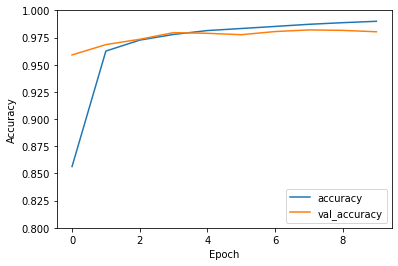

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# CIFAR-10

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)
height, width = 32, 32
num_classes = 10

In [ ]:
"RESNET MIXER"
n_repeat = 4
depth = 16

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = resnet_mixer(height, width * channels, depth, num_classes, n_repeat)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)

print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_201 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_189 (Reshape)        (None, 32, 96)            0         
_________________________________________________________________
model_168 (Functional)       (None, 10)                1349742   
Total params: 1,349,742
Trainable params: 1,349,742
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 28s 33ms/step - loss: 1.9549 - accuracy: 0.3012 - val_loss: 1.5427 - val_accuracy: 0.4564
Epoch 2/10
782/782 [==============================] - 25s 32ms/step - loss: 1.4790 - accuracy: 0.4758 - val_loss: 1.3675 - val_accuracy: 0.5067
Epoch 3/10
782/782 [==============================] - 25s 32ms/step - loss: 1.3239 -

In [ ]:
"RESNET MIXER"
n_repeat = 16
depth = 1

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = resnet_mixer(height, width * channels, depth, num_classes, n_repeat)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)

print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_217 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_205 (Reshape)        (None, 32, 96)            0         
_________________________________________________________________
model_182 (Functional)       (None, 10)                333216    
Total params: 333,216
Trainable params: 333,216
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 20s 16ms/step - loss: 1.8379 - accuracy: 0.3303 - val_loss: 1.3806 - val_accuracy: 0.5074
Epoch 2/10
782/782 [==============================] - 12s 15ms/step - loss: 1.3012 - accuracy: 0.5378 - val_loss: 1.2553 - val_accuracy: 0.5508
Epoch 3/10
782/782 [==============================] - 11s 15ms/step - loss: 1.1318 - acc

In [ ]:
"DEEPER REPEATED PATCHLESS MIXER ROW-COL CLASSIFICATION"
num_classes = 10
hidden_dim = 64
n_repeat = 16
depth = 8

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = repeated_patchless_mixer_2(height, width * channels, hidden_dim, depth, num_classes, n_repeat)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)

print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_184 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_172 (Reshape)        (None, 32, 96)            0         
_________________________________________________________________
model_156 (Functional)       (None, 10)                2274362   
Total params: 2,274,362
Trainable params: 2,274,362
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
219/782 [=======>......................] - ETA: 36s - loss: 2.1462 - accuracy: 0.1967

KeyboardInterrupt: ignored

In [ ]:
"DEEPER REPEATED PATCHLESS MIXER"
num_classes = 10
hidden_dim = 32
n_repeat = 3
depth = 8
inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = repeated_patchless_mixer(height, width * channels, hidden_dim, depth, num_classes, n_repeat)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_156 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_144 (Reshape)        (None, 32, 96)            0         
_________________________________________________________________
model_129 (Functional)       (None, 10)                233482    
Total params: 233,482
Trainable params: 233,482
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 1.9038 - accuracy: 0.3210 - val_loss: 1.5143 - val_accuracy: 0.4565
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 1.4937 - accuracy: 0.4722 - val_loss: 1.3783 - val_accuracy: 0.5032
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 1.3583 - accuracy:

In [ ]:
"DEEPER REPEATED PATCHLESS MIXER"
num_classes = 10
hidden_dim = 64
n_repeat = 16
depth = 4
inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = repeated_patchless_mixer(height, width * channels, hidden_dim, depth, num_classes, n_repeat)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_164 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_152 (Reshape)        (None, 32, 96)            0         
_________________________________________________________________
model_137 (Functional)       (None, 10)                1295370   
Total params: 1,295,370
Trainable params: 1,295,370
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 36s 38ms/step - loss: 1.8305 - accuracy: 0.3535 - val_loss: 1.5645 - val_accuracy: 0.4470
Epoch 2/10
782/782 [==============================] - 29s 37ms/step - loss: 1.4588 - accuracy: 0.4841 - val_loss: 1.3692 - val_accuracy: 0.5135
Epoch 3/10
782/782 [==============================] - 29s 37ms/step - loss: 1.3257 -

In [ ]:
height, width = 32, 32
hidden_size = 512
size = 16
num_classes = 10

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
blender = blender_model(height, width * channels, hidden_size, size, num_classes)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=blender)
print(model.summary())

optimizer = tf.keras.optimizers.Adam(0.1, epsilon=0.1)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_106 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_100 (Reshape)        (None, 32, 96)            0         
_________________________________________________________________
model_88 (Functional)        (None, 10)                1081514   
Total params: 1,081,514
Trainable params: 1,081,514
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 12s 14ms/step - loss: 1.9332 - accuracy: 0.2934 - val_loss: 1.5982 - val_accuracy: 0.4258
Epoch 2/10
782/782 [==============================] - 11s 14ms/step - loss: 1.5638 - accuracy: 0.4408 - val_loss: 1.4949 - val_accuracy: 0.4674
Epoch 3/10
782/782 [==============================] - 11s 14ms/step - loss: 1.4697 - 

313/313 - 2s - loss: 1.2273 - accuracy: 0.5633


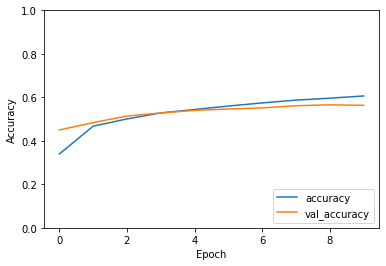

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
height, width, channels = train_images.shape[-3:]
hidden_dim = 256
depth = 16
num_classes = 10

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
mixer = patchless_mixer(height, width * channels, hidden_dim, hidden_dim, depth, num_classes)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=mixer)
print(model.summary())

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_114 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_108 (Reshape)        (None, 32, 96)            0         
_________________________________________________________________
model_96 (Functional)        (None, 10)                3285002   
Total params: 3,285,002
Trainable params: 3,285,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1563/1563 [==============================] - 52s 33ms/step - loss: 1.8906 - accuracy: 0.3206 - val_loss: 1.4518 - val_accuracy: 0.4840
Epoch 2/10
1563/1563 [==============================] - 52s 33ms/step - loss: 1.4150 - accuracy: 0.4981 - val_loss: 1.3200 - val_accuracy: 0.5316
Epoch 3/10
1563/1563 [==============================] - 52s 33ms/step - loss: 1.2

313/313 - 1s - loss: 1.1823 - accuracy: 0.6108


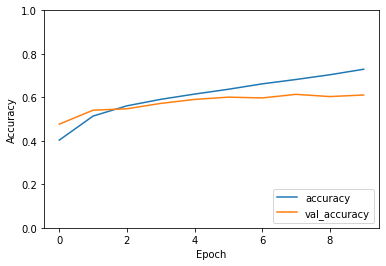

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)